In [1]:
import os
import tifffile
import rasterio

import cv2
import numpy as np

import leafmap.leafmap as leafmap
from samgeo import SamGeo2

import geopandas as gpd
import pickle
from pyproj import Transformer

from utils.tools import get_raster_data, get_raster_profile, save_raster_and_write_meta
import matplotlib.pyplot as plt


## A. Getting a satellite image and export it to a GeoTiff file

In [ ]:
m = leafmap.Map(center=[12.94316, 101.001263], zoom=16, height="800px")
m.add_basemap("Satellite")
m

In [ ]:
if m.user_roi is not None:
    bbox = m.user_roi_bounds()
    coordinates = m.user_rois['features'][0]['geometry']['coordinates'][0]
else:
    bbox = [100.9230026816609, 13.054297390119896, 100.9261026816609, 13.052397390099848] 
    coordinates = [
        [bbox[0], bbox[3]],  # Top-left corner (min_lon, max_lat)
        [bbox[2], bbox[3]],  # Top-right corner (max_lon, max_lat)
        [bbox[2], bbox[1]],  # Bottom-right corner (max_lon, min_lat)
        [bbox[0], bbox[1]],  # Bottom-left corner (min_lon, min_lat)
        [bbox[0], bbox[3]]   # Closing the polygon by repeating the first point
        ]

In [ ]:
clipped_satellite_file = "clipped_satellite.tif"  

leafmap.map_tiles_to_geotiff(
    output=clipped_satellite_file, bbox=bbox, zoom=18, source="Satellite", overwrite=True
)

In [ ]:
selected_coordinates = {} 
selected_coordinates["bbox"] = bbox
selected_coordinates["coordinates"] = coordinates
 

file_path = 'selected_coordinates.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(selected_coordinates, file)

## B. Processing and saving GeoTiff files

In [6]:
clipped_image_file = "clipped_image.tif"
clipped_satellite_file = "clipped_satellite.tif"

clipped_image     = tifffile.imread(clipped_image_file)  
clipped_satellite = tifffile.imread(clipped_satellite_file) 

In [7]:
normalized_img = cv2.normalize(clipped_image, None, 0, 255, cv2.NORM_MINMAX)  # Normalize to 0-1 range
normalized_img_uint8 = normalized_img.astype(np.uint8)  

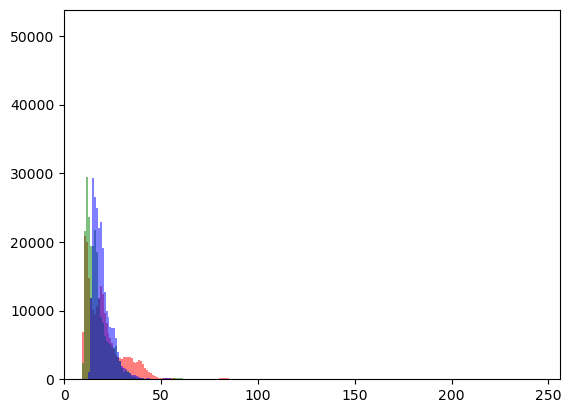

In [8]:
red_channel = normalized_img_uint8[:, :, 0].ravel()
green_channel = normalized_img_uint8[:, :, 1].ravel()
blue_channel = normalized_img_uint8[:, :, 2].ravel()

# Compute histograms for each channel
hist_r, _ = np.histogram(red_channel, bins=256, range=(0, 255))
hist_g, _ = np.histogram(green_channel, bins=256, range=(0, 255))
hist_b, bin_edges = np.histogram(blue_channel, bins=256, range=(0, 255))

plt.bar(bin_edges[:-1], hist_r, width=1, color='r', edgecolor='none', alpha=0.5, label='Red')
plt.bar(bin_edges[:-1], hist_g, width=1, color='g', edgecolor='none', alpha=0.5, label='Green') 
plt.bar(bin_edges[:-1], hist_b, width=1, color='b', edgecolor='none', alpha=0.5, label='Blue')  
plt.xlim([0, 256]) # Set the x-axis range from 0 to 256
plt.show()

In [9]:
from skimage import exposure
p2, p98 = np.percentile(red_channel, (2, 98))
red_ch_rescale = exposure.rescale_intensity(red_channel, in_range=(p2, p98))

p2, p98 = np.percentile(green_channel, (2, 98))
green_ch_rescale = exposure.rescale_intensity(green_channel, in_range=(p2, p98))

p2, p98 = np.percentile(blue_channel, (2, 98))
blue_ch_rescale = exposure.rescale_intensity(blue_channel, in_range=(p2, p98))

normalized_img_uint8[:,:,0] = red_ch_rescale.reshape(normalized_img_uint8.shape[0], normalized_img_uint8.shape[1])
normalized_img_uint8[:,:,1] = green_ch_rescale.reshape(normalized_img_uint8.shape[0], normalized_img_uint8.shape[1])
normalized_img_uint8[:,:,2] = blue_ch_rescale.reshape(normalized_img_uint8.shape[0], normalized_img_uint8.shape[1])

In [12]:
# Save output
meta_source_file = 'clipped_image.tif'
destination_image_name_file = 'post_clipped_image.tif' 

normalized_img_uint8 = normalized_img_uint8.transpose(2, 0, 1)  
save_raster_and_write_meta(normalized_img_uint8, destination_image_name_file, meta_source_tif=meta_source_file)
 

Modified image saved to post_clipped_image.tif


In [ ]:
clipped_satellite_file = "clipped_satellite.tif"
imgA, _ = get_raster_data(clipped_satellite_file) 
imgA = np.transpose(imgA, (1, 2, 0))  # Convert from (bands, height, width) to (height, width, bands)

post_clipped_image = "post_clipped_image.tif"
imgB, _ = get_raster_data(post_clipped_image) 
imgB = np.transpose(imgB, (1, 2, 0))  # Convert from (bands, height, width) to (height, width, bands)

Dataset name: clipped_satellite.tif
File mode: r
Number of bands: 3
Image width: 578 pixels
Image height: 364 pixels
Coordinate Reference System (CRS): EPSG:3857
Data shape: (3, 364, 578)
Data type: uint8
Dataset name: post_clipped_image.tif
File mode: r
Number of bands: 4
Image width: 677 pixels
Image height: 426 pixels
Coordinate Reference System (CRS): EPSG:32647
Data shape: (4, 426, 677)
Data type: uint8


(np.float64(-0.5), np.float64(676.5), np.float64(425.5), np.float64(-0.5))

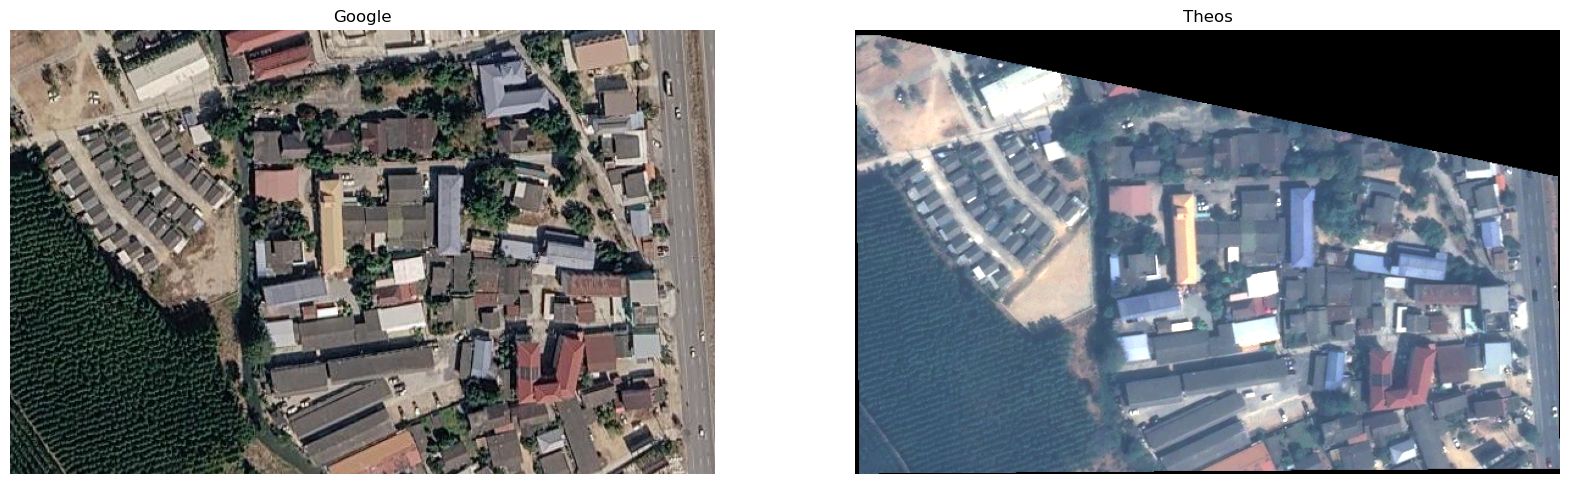

In [14]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(20, 15))

axs[0].imshow(imgA[:,:,0:3])  # Display the first three channels (RGB) of the clipped image
axs[0].set_title('Google') # Set a title for the first subplot
axs[0].axis('off') # Optional: turn off axis ticks for a cleaner image display

axs[1].imshow(imgB[:,:,0:3])  # Display the first three channels (RGB) of the clipped satellite image
axs[1].set_title('Theos') # Set a title for the second subplot
axs[1].axis('off') #

In [16]:
m = leafmap.Map()
m.add_raster(clipped_satellite_file, layer_name="Google")
m.add_raster(clipped_image_file, layer_name="Theos")
m.add_raster(post_clipped_image, layer_name="Theos (enhanced)")
m

Map(center=[13.053346999999999, 100.92455100000001], controls=(ZoomControl(options=['position', 'zoom_in_text'…